# Setup

In [203]:
# !pip install --upgrade gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [204]:
from sklearn.decomposition import LatentDirichletAllocation

In [205]:
import matplotlib.pyplot as plt

In [206]:
import pandas as pd
import numpy as np

In [207]:
#!pip install mglearn

In [208]:
import mglearn
from collections import Counter

In [209]:
from textblob import TextBlob

In [210]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# Clean Data

In [211]:
df = pd.read_csv("data/Death_Row_Data.csv", encoding = "latin1")

In [212]:
words = df['Last Statement']
print("Number of executions: {}".format(len(words)))

Number of executions: 549


In [213]:
words = words.dropna()
print("Number of statements: {}".format(len(words)))

Number of statements: 447


## Extra symbols

Webscraping gave me none english characters. clean up text

In [214]:
words = [doc.replace("\x99","") for doc in words]

In [215]:
words = [doc.replace("\x98","") for doc in words]

In [216]:
words = [doc.replace("\x93","") for doc in words]

In [217]:
words = [doc.replace("\x80","") for doc in words]

In [218]:
words = [doc.replace("\x9d","") for doc in words]

In [219]:
words = [doc.replace("\x9c","") for doc in words]

In [220]:
words = [doc.replace("â","") for doc in words]

In [221]:
words = [doc.replace("\'","") for doc in words]

In [222]:
words = [doc.replace("\n","") for doc in words]

In [223]:
words = [doc.replace("\r","") for doc in words]

## Drop "No statement"

In [224]:
def remove_all_values(the_list, val):
   return [value for value in the_list if value != val]

In [225]:
words = remove_all_values(words,'None')

In [226]:
words = remove_all_values(words,'None.')

In [227]:
words = remove_all_values(words,'No')

In [228]:
words = remove_all_values(words,'This offender declined to make a last statement.  ')

In [229]:
words = remove_all_values(words,'This offender declined to make a last statement.')

In [230]:
words = remove_all_values(words,'No, I have no final statement. ')

In [231]:
words = remove_all_values(words,'No last statement.')

In [232]:
print("Number of statements: {}".format(len(words)))

Number of statements: 436


## Length of statements

In [233]:
#checking length of statements

lengths = []
for doc in words:
    lengths.append(len(doc.split()))
    if len(doc.split())<=4:
        print(doc)
lengths.sort()
Counter(lengths)

I love you Israel. 
 Bye, Im Ready. 
 Profanity directed toward staff.  
 Santajaib Singh Ji.  
Goodbye.
Yes, I do.
Ill see you.
Peace.
High Flight (aviation poem)
Thanked his family.
Im ready, Warden.


Counter({1: 2,
         3: 6,
         4: 3,
         5: 3,
         6: 2,
         7: 4,
         8: 5,
         9: 2,
         10: 3,
         11: 4,
         12: 3,
         13: 4,
         14: 5,
         15: 2,
         16: 4,
         17: 8,
         18: 3,
         19: 4,
         20: 6,
         21: 3,
         22: 4,
         23: 2,
         24: 6,
         25: 6,
         26: 1,
         27: 5,
         28: 6,
         29: 4,
         30: 2,
         31: 3,
         32: 8,
         33: 4,
         34: 2,
         35: 7,
         36: 2,
         37: 1,
         38: 1,
         39: 2,
         40: 4,
         42: 3,
         43: 4,
         44: 2,
         45: 7,
         46: 3,
         47: 3,
         48: 4,
         49: 2,
         50: 2,
         51: 2,
         52: 2,
         53: 2,
         54: 1,
         55: 1,
         56: 5,
         57: 2,
         58: 3,
         59: 1,
         60: 1,
         61: 2,
         62: 3,
         63: 2,
         64: 2,
         65: 4,


In [234]:
# create list of shorter than X words statements

words_short = list(filter(lambda x: len(x.split()) < 2400, words))
print("Number of statements: {}".format(len(words_short)))

Number of statements: 436


In [235]:
words = words_short

## Lowercase

In [236]:
words_lower = []
for doc in words:  
    doc = doc.lower()
    words_lower.append(doc)
    
words = words_lower

# Bag of word

In [237]:
# contain innocent

def containing(this):
    counter = 0
    total = len(words)

    for doc in words:
        for each in this:
            if each in doc:
                counter += 1
                break
                
    return round((counter/total*100),1),counter

In [322]:
print('love and family', containing(['love','family','families','mom','mama','mother',
                                     'father','wife','kid','children','child','brother','sister','aunt']))

love and family (80.5, 351)


In [351]:
print('apology',containing(['orry','apolog','forgiveness','forgive','peace','remorse']))

apology (50.2, 219)


In [350]:
print('religious',containing(['god','allah','jesus','christ','savior','lord','pray','amen','heavenly']))

religious (47.2, 206)


In [328]:
print('thank you',containing(['thank']))

thank you (35.1, 153)


In [353]:
print('ready warden', containing(['ready','warden']))

ready warden (30.0, 131)


In [321]:
print('innocent',containing(['innocent']))

innocent (6.4, 28)


In [281]:
containing(['victim'])

(8.3, 36)

# Jitter function

In [294]:
def rand_jitter_pos(arr):
    stdev = .03*(max(arr)-min(arr))
    return arr + abs(np.random.randn(len(arr))) * stdev

def rand_jitter(arr):
    stdev = .03*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=30, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, 
           alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, c=c, marker=marker, cmap=cmap, 
                   norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, 
                   verts=verts, hold=hold, **kwargs)

#better jitter

constant = 0.03

def rand_jitter_good(arr,constant):
    stdev = constant*(max(arr)-min(arr))
    arr_new = []
    for item in arr:
        if item < -0.9:
            item = item + abs(np.random.randn(1)[0]) * stdev
        elif item > 0.9:
            item = item - abs(np.random.randn(1)[0]) * stdev
        else:
            item = item + np.random.randn(1)[0] * stdev
        arr_new.append(item)
    return arr_new

def rand_jitter_good_pos(arr,constant):
    stdev = constant*(max(arr)-min(arr))
    arr_new = []
    for item in arr:
        if item < 0.1:
            item = item + abs(np.random.randn(1)[0]) * stdev
        elif item > 0.9:
            item = item - abs(np.random.randn(1)[0]) * stdev
        else:
            item = item + np.random.randn(1)[0] * stdev
        arr_new.append(item)
    return arr_new

def jitter_good(x, y, s=40, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, 
           alpha=None, linewidths=None, verts=None, hold=None, **kwargs):
    return plt.scatter(rand_jitter_good_pos(x,constant), rand_jitter_good(y,constant), s=s, c=c, marker=marker, cmap=cmap, 
                   norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, 
                   verts=verts, hold=hold, **kwargs)

# Sentiment of last words

In [282]:
def p_and_s(words):
    polarity = []
    subjectivity = []

    for doc in words:
        state = str(doc)
        a = list(TextBlob(state).sentiment)
        polarity.append(a[0])
        subjectivity.append(a[1])
    
    return polarity, subjectivity

## Last Words

In [283]:
print("Number of last words: {}".format(len(words)))

Number of last words: 436


In [284]:
polarity, subjectivity = p_and_s(words)

In [285]:
print("Last words")
print("Average polarity: {}".format(sum(polarity) / float(len(polarity))))
print("Average subjectivity: {}".format(sum(subjectivity) / float(len(subjectivity))))

Last words
Average polarity: 0.16447056371623117
Average subjectivity: 0.5496329715698399


In [378]:
constant = 0.03
subjectivity_j, polarity_j = rand_jitter_good_pos(subjectivity,constant), rand_jitter_good(polarity,constant)

In [379]:
f=open('lastwords_sem.csv','w')
for i,j in zip(subjectivity_j, polarity_j):
    f.write(str(i)+","+str(j)+"\n")
f.close()

## Survey

In [286]:
df_survey = pd.read_csv("Pollfish_Survey_Death_Row_403827Q1.csv")

In [287]:
survey = df_survey['Answers']
print("Number of responses: {}".format(len(survey)))

Number of responses: 100


In [288]:
polarity_s, subjectivity_s = p_and_s(survey)

In [289]:
print("Survey")
print("Average polarity: {}".format(sum(polarity_s) / float(len(polarity_s))))
print("Average subjectivity: {}".format(sum(subjectivity_s) / float(len(subjectivity_s))))

Survey
Average polarity: -0.1932904761904762
Average subjectivity: 0.5303174603174603


In [374]:
constant = 0.03
subjectivity_s_j, polarity_s_j = rand_jitter_good_pos(subjectivity_s,constant), rand_jitter_good(polarity_s,constant)

In [375]:
f=open('survey_sem.csv','w')
for i,j in zip(subjectivity_s_j, polarity_s_j):
    f.write(str(i)+","+str(j)+"\n")
f.close()

## Poems

In [290]:
df_poems = pd.read_csv("Death_poems.csv")

In [291]:
poems = df_poems['Text']
print("Number of poems: {}".format(len(poems)))

Number of poems: 15


In [292]:
polarity_p, subjectivity_p = p_and_s(poems)

In [293]:
print("Poems")
print("Average polarity: {}".format(sum(polarity_p) / float(len(polarity_p))))
print("Average subjectivity: {}".format(sum(subjectivity_p) / float(len(subjectivity_p))))

Poems
Average polarity: 0.1704639720273341
Average subjectivity: 0.5752102979715048


In [376]:
constant = 0.03
subjectivity_p_j, polarity_p_j = rand_jitter_good_pos(subjectivity_p,constant), rand_jitter_good(polarity_p,constant)

In [377]:
f=open('poem_sem.csv','w')
for i,j in zip(subjectivity_p_j, polarity_p_j):
    f.write(str(i)+","+str(j)+"\n")
f.close()

## Plot

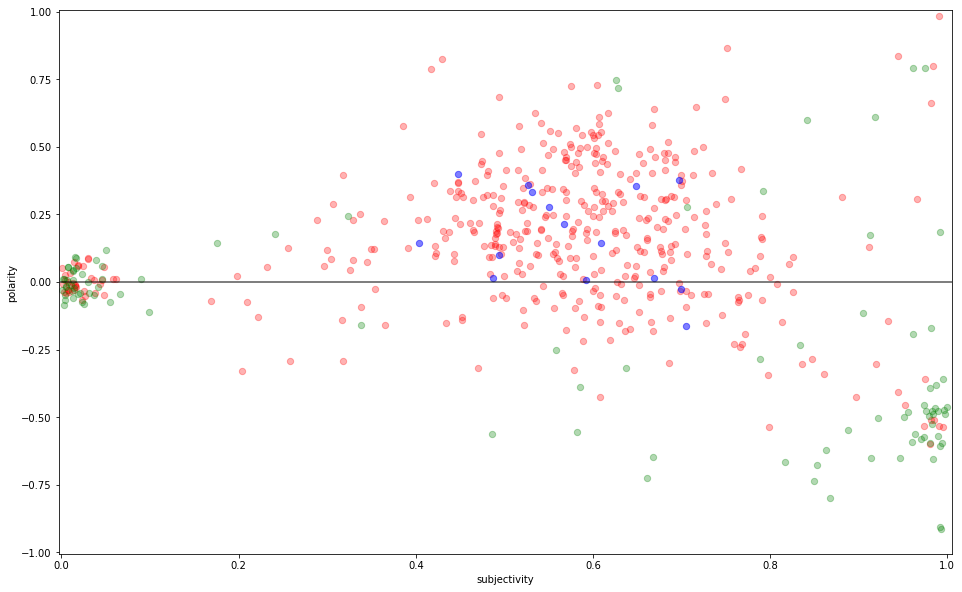

In [295]:
x = subjectivity
y = polarity

plt.figure(figsize=(16,10))
jitter_good(x, y, c="r", alpha=0.3)
jitter_good(subjectivity_s, polarity_s, c="green", alpha=0.3)
plt.plot([0,1.05], [0,0], linewidth=2,color="black", alpha=0.5)
plt.scatter(subjectivity_p, polarity_p, c="blue", alpha=0.5,s=40)
plt.xlabel("subjectivity")
plt.ylabel("polarity")
plt.xlim(-0.003,1.005)
plt.ylim(-1.005,1.005)
plt.show()

## Reddit test

In [296]:
doc = " think my grandfather is going to die today, and I'm scared that I won't be sad. To me, he was a dick to everyone. After about age 22 or something, I realized I didn't have to like him, and I didn't owe him anything just because he was old. I didn't like being around him, he wasn't nice to my mom or my uncle, and probably not that great to my nana. I basically shunned him for the last 7 or so years... however, today is probably the day he is going to die. My mom is telling me he is in bad shape but won't tell me until she sees me in person — he may already be dead. I love my mom though, and however I feel about my grandfather is irrelevant because I recognize that that is my mom's dad, and it's the only dad she's ever had. Nobody is ever the right age to lose one of their parents, and I really feel for her. My mom doesn't know the extent of how much I don't like my grandfather, but other people do. I'm afraid that I won't look sad or be sad when she tells me he has died. I don't know what to do. I'm afraid of her telling me he's died because of my lack of a reaction. Has anyone here been in a similar situation? I'm ready to give my mom full empathy and whatever I can do, but I'm just afraid that I'll upset her by not looking or feeling sad at all. How can I handle this?"

In [297]:
doc = "What else can I say. The man had a truly terrible life, made the best of it all always, and now he's dying a horrifically terrible death. I don't believe in God regardless, but if I did I no longer would after witnessing this man's misfortune. Misfortune that he didn't bring upon himself, either. I wish he would just die in his sleep. I almost want to pray to that aforementioned God out of desperation."

In [298]:
doc = "I’ve struggled with Anxiety my whole life for various reasons. Recently I kicked it to the curb for the most part, but also a few scary life experiences have made me scared of dying young. Last night I came home from a friend’s and heard “only the good die young” on the radio. Opened up YouTube to come across nothing but videos about death and character deaths on my feed and opened up Netflix to find a majority of titles linked to death and horror. Is this just my anxiety attempting to get the best of me or is this something else? What do you guys think?"

In [299]:
doc = "I lie awake, crying, screaming my lungs out each day in bed that i don’t want to die. That even though im atheist i want there to be an afterlife, even in hellish pain. I just want to see my mother after i pass. I am mortified. Is there nothing, just blackness, fully conscious? Or do you find other souls? I would end my own life right now if i knew there was an afterlife so i can see my family again. How can i cope with this distress?"

In [300]:
TextBlob(doc).sentiment

Sentiment(polarity=0.13214285714285715, subjectivity=0.6021428571428571)

# Parse words

In [301]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [302]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [303]:
# Create a TfidfVectorizer for parsing/counting words
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, stop_words=ENGLISH_STOP_WORDS)

In [304]:
x = tfidf.fit_transform(words)

In [305]:
feature_names = tfidf.get_feature_names()
len(feature_names)

1349

In [306]:
# Create a CountVectorizer for parsing/counting words
vect = CountVectorizer(ngram_range=(1,3), min_df=3, stop_words=ENGLISH_STOP_WORDS,strip_accents='unicode')

In [307]:
x = vect.fit_transform(words)

In [308]:
feature_names = vect.get_feature_names()
len(feature_names)

1521

# LDA

In [309]:
num_topics = 12

In [310]:
lda = LatentDirichletAllocation(n_components=num_topics, max_iter = 25, random_state=0, 
                                n_jobs=-1, learning_method='online')

In [311]:
document_topics = lda.fit_transform(x)

In [312]:
print("lda.components_.shape: {}".format(lda.components_.shape))

lda.components_.shape: (12, 1521)


## Interperate LDA

In [313]:
pyLDAvis.sklearn.prepare(lda, x, vect)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      69.594779        1       1  0.149283  0.003096
4      16.295126        1       2  0.266536  0.083236
8       3.959638        1       3 -0.005842 -0.281332
7       3.463440        1       4 -0.137370  0.026336
11      2.563749        1       5  0.084865 -0.088301
10      1.028531        1       6 -0.083302  0.029089
6       1.002915        1       7 -0.039925  0.082468
0       0.835157        1       8 -0.075392  0.043919
1       0.494937        1       9 -0.049174  0.034530
3       0.304717        1      10 -0.041132  0.024667
5       0.267503        1      11 -0.033321  0.026022
9       0.189508        1      12 -0.035225  0.016271, topic_info=     Category        Freq         Term       Total  loglift  logprob
term                                                                
1266  Default  261.000000        thank  261.000000  30.0000  30.0000
772   Default  646.000000         love  646.000000  29.0000  29.0000
304   Default  306.000000       family  306.000000  28.0000  28.0000
420   Default  206.000000          god  206.000000  27.0000  27.0000
703   Default  151.000000         life  151.000000  26.0000  26.0000
227   Default  116.000000          did  116.000000  25.0000  25.0000
568   Default  175.000000           im  175.000000  24.0000  24.0000
714   Default  200.000000         like  200.000000  23.0000  23.0000
601   Default   98.000000        jesus   98.000000  22.0000  22.0000
367   Default  148.000000      forgive  148.000000  21.0000  21.0000
753   Default  132.000000         lord  132.000000  20.0000  20.0000
1392  Default  221.000000         want  221.000000  19.0000  19.0000
1474  Default  188.000000         yall  188.000000  18.0000  18.0000
150   Default   52.000000       christ   52.000000  17.0000  17.0000
213   Default   85.000000        death   85.000000  16.0000  16.0000
1248  Default  129.000000         tell  129.000000  15.0000  15.0000
1065  Default   41.000000         said   41.000000  14.0000  14.0000
1504  Default  106.000000          yes  106.000000  13.0000  13.0000
1078  Default  166.000000          say  166.000000  12.0000  12.0000
1502  Default   66.000000        years   66.000000  11.0000  11.0000
1320  Default   62.000000         time   62.000000  10.0000  10.0000
1202  Default   32.000000    statement   32.000000   9.0000   9.0000
35    Default   38.000000    apologize   38.000000   8.0000   8.0000
954   Default  113.000000       people  113.000000   7.0000   7.0000
156   Default   61.000000         come   61.000000   6.0000   6.0000
18    Default   22.000000        allah   22.000000   5.0000   5.0000
733   Default   36.000000   like thank   36.000000   4.0000   4.0000
1213  Default   78.000000       strong   78.000000   3.0000   3.0000
338   Default   75.000000       father   75.000000   2.0000   2.0000
652   Default  296.000000         know  296.000000   1.0000   1.0000
...       ...         ...          ...         ...      ...      ...
955   Topic12    0.022502   people god    3.367561   1.2601  -7.3255
393   Topic12    0.022486       fought    3.142659   1.3285  -7.3262
1155  Topic12    0.022985        sorry  236.933680  -2.9722  -7.3042
945   Topic12    0.022918        peace  103.319255  -2.1451  -7.3071
772   Topic12    0.022763         love  646.242215  -3.9853  -7.3139
141   Topic12    0.022744       change   17.356876  -0.3690  -7.3148
538   Topic12    0.022729         hope  142.220440  -2.4730  -7.3154
1504  Topic12    0.022666          yes  106.034951  -2.1822  -7.3182
652   Topic12    0.022638         know  296.614009  -3.2121  -7.3194
6     Topic12    0.022636       accept   10.973896   0.0848  -7.3195
843   Topic12    0.022623         make   45.377158  -1.3353  -7.3201
937   Topic12    0.022617         past   12.236303  -0.0249  -7.3203
1502  Topic12    0.022613        years   66.130309  -1.7124  -7.3205
947   Topic12    0.022612  

In [337]:
sorting = np.argsort(lda.components_,axis=1)[:,::-1]
feature_names = np.array(vect.get_feature_names())
mglearn.tools.print_topics(topics=range(num_topics),feature_names=feature_names,
                           sorting=sorting,topics_per_chunk=6,n_words=20)

topic 0       topic 1       topic 2       topic 3       topic 4       topic 5       
--------      --------      --------      --------      --------      --------      
brings        born          love          polunsky      love          guilty        
crime         warrior       know          proceed wardenyall          texas         
did           im            family        proceed       tell          fact          
hope brings   mad           sorry         country       strong        august        
brings closuredie           thank         church        want          state texas   
hope brings closurehome jesus    god           filled        stay          demand        
did commit    miracle       like          demand        family        relief        
commit        trouble       want          lift          know          state         
crime did commitcaused like   say           solace        stay strong   sentence      
crime did     home lord     im            community     lo

In [338]:
df_document_topics = pd.DataFrame(document_topics, columns=["Topic"+str(i+1) for i in range(num_topics)])
df_document_topics.head()

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12
0,0.008333,0.008333,0.492165,0.008333,0.424501,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,0.004902,0.004902,0.946078,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902,0.004902
2,0.003472,0.003473,0.961804,0.003472,0.003472,0.003472,0.003472,0.003473,0.003472,0.003472,0.003472,0.003472
3,0.013889,0.013889,0.847221,0.013889,0.013890,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889,0.013889
4,0.001055,0.001055,0.988396,0.001055,0.001055,0.001055,0.001055,0.001055,0.001055,0.001055,0.001055,0.001055


In [339]:
#document_topics['Words'] = words

In [340]:
most_likely_topics = df_document_topics.idxmax(axis=1)

In [342]:
most_likely_topics.groupby(most_likely_topics).count()

Topic1       5
Topic11      2
Topic12     11
Topic2       4
Topic3     321
Topic5      72
Topic6       1
Topic7       8
Topic8       4
Topic9       8
dtype: int64

## Print specific topic docs

In [344]:
topics = np.array([range(num_topics)])

In [345]:
topic_4 = np.argsort(document_topics[:,2])

for i in topic_4[:5]:
    print(i,'.'.join(words[i].split(".")[:2]))

174  tell beth and them i am sorry, truly sorry for the pain that i caused your family.  i truly mean that too
215  can you hear me, chris?  the lord is my shepherd; i shall not want.  he makes me to lie down in green pastures; he leads me beside the still waters
240 the lord is my shepherd, i shall not want. he maketh me lie down in green pastures; he leadeth me beside the still waters, he restoreth my soul
92 collins family, i know your not going to get the closure you are looking for tonight. i wish you the best
310  mama isabel told me to tell you hello. holy, holy, holy! lord god almighty! early in the morning our song shall rise to thee; holy, holy, holy, merciful and mighty! god in three persons, blessed trinity


In [346]:
topic = np.argsort(document_topics[:,1])

for i in topic[:10]:
    print(i,'  ','.'.join(words[i].split(".")[:2]))

287     i would like to say that i did not kill bobby lambert. that im an innocent black man that is being murdered
308     i want to start out by acknowledging the love that ive had in my family. no man in this world has had a better family than me
174     tell beth and them i am sorry, truly sorry for the pain that i caused your family.  i truly mean that too
296    yes, sir. james webb, i dont know which one you are out there
294     can they talk back? say i pray for it, i accept it. pray with me
266     yes, first i would like to speak to the victims family.  first of all, i would like to say that i do not know any of yall and that is unfortunate, because i would like to apologize to each and every one of you individually
275    i am saying, i want yall to keep your heads up, hold on and stay strong for everybody. i mean ah, i dont want yall to look at me like i am a killer or something man, cause i aint no killer
288     verbal: i have a written statement for the press. it will b

# Affect API

In [74]:
import affectr

/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
/anaconda3/lib/python3.6/site-packages/_pytest/fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)


ModuleNotFoundError: No module named 'client'

In [ ]:
affectr.set_details("your username", "your password")

In [ ]:
affectr.client.classify_intent(
    "We are planning to implement a real-time data service. " +
    "What are the advantages/disadvantages of using a Foobar-compliant database over Hype.js?")[0].intentType)